In [14]:
%pip install -Uq evaluate
%pip install -Uq rouge-score
%pip install -Uq bleu
%pip install -Uq ragas
%pip install -Uq langchain-aws

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.2 requires nvidia-ml-py3==7.352.0, which is not installed.
autogluon-multimodal 1.2 requires jsonschema<4.22,>=4.18, but you have jsonschema 4.23.0 which is incompatible.
autogluon-multimodal 1.2 requires nltk<3.9,>=3.4.5, but you have nltk 3.9.1 which is incompatible.
autogluon-multimodal 1.2 requires omegaconf<2.3.0,>=2.1.1, but you have omegaconf 2.3.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-progress 0.1.1 requires langchain-comm

In [20]:
import json
import os
from typing import Any, Dict, List, Optional

# External Dependencies:
import pandas as pd  # For working with tabular data
import boto3, uuid
from botocore.response import StreamingBody

from datasets import Dataset, load_dataset
from random import sample
from asyncio import run

import evaluate as hf_evaluate

# Langchain
from langchain_aws.chat_models.sagemaker_endpoint import ChatSagemakerEndpoint, ChatModelContentHandler
from langchain_core.messages import HumanMessage, AIMessageChunk, SystemMessage
from langchain_aws.embeddings import BedrockEmbeddings
from langchain_community.embeddings import SagemakerEndpointEmbeddings


# Sagemaker
import sagemaker
from sagemaker.huggingface import HuggingFaceModel
from sagemaker.huggingface import get_huggingface_llm_image_uri
from sagemaker.utils import name_from_base
from sagemaker import get_execution_role

# RAGAS
import ragas
from ragas.run_config import RunConfig
from ragas.metrics.base import MetricWithLLM, MetricWithEmbeddings
from ragas import evaluate as ragas_evaluate
from ragas.metrics import Faithfulness, ResponseRelevancy
from ragas.metrics import answer_relevancy, faithfulness, context_precision
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.dataset_schema import SingleTurnSample

In [15]:

# Load the BLEU evaluation metric
bleu = hf_evaluate.load("bleu")
rouge = hf_evaluate.load("rouge")

2025-04-05 18:55:46.275981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 18:55:46.291988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 18:55:46.296895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 18:55:46.308220: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
evaluation_dataset = load_dataset("json", data_files="eval.json", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [17]:
ground_truth = []
base_predictions = []
sft_predictions = []

for eval_item in evaluation_dataset:

    ground_truth.append(eval_item["ground_truth"])
    base_predictions.append(eval_item['base'])
    sft_predictions.append(eval_item['tuned'])


base_bleu_results = bleu.compute(predictions=base_predictions, references=ground_truth)
base_rouge_results = rouge.compute(predictions=base_predictions, references=ground_truth)

# Compute the BLEU score
sft_bleu_results = bleu.compute(predictions=sft_predictions, references=ground_truth)
sft_rouge_results = rouge.compute(predictions=sft_predictions, references=ground_truth)

base_scores = (base_bleu_results | base_rouge_results)
sft_scores = (sft_bleu_results | sft_rouge_results)

print("=======BASE MODEL=======")
print(base_scores)
print("=======TUNED MODEL=======")
print(sft_scores)

[04/05/25 18:55:58] INFO     Using default tokenizer.                                            ]8;id=556870;file:///opt/conda/lib/python3.11/site-packages/rouge_score/rouge_scorer.py\rouge_scorer.py]8;;\:]8;id=165821;file:///opt/conda/lib/python3.11/site-packages/rouge_score/rouge_scorer.py#83\83]8;;\

[04/05/25 18:56:14] INFO     Using default tokenizer.                                            ]8;id=119227;file:///opt/conda/lib/python3.11/site-packages/rouge_score/rouge_scorer.py\rouge_scorer.py]8;;\:]8;id=943144;file:///opt/conda/lib/python3.11/site-packages/rouge_score/rouge_scorer.py#83\83]8;;\

=======BASE MODEL=======
{'bleu': 0.4114756154832229, 'precisions': [0.6616061544758556, 0.45710818427201044, 0.3469485627025168, 0.27320760722527254], 'brevity_penalty': 1.0, 'length_ratio': 1.0314523944310647, 'translation_length': 322497, 'reference_length': 312663, 'rouge1': 0.6611996106659694, 'rouge2': 0.45891180129876374, 'rougeL': 0.47968244426749934, 'rougeLsum': 0.4794930604388219}
=======TUNED MODEL=======
{'bleu': 0.47653356485280896, 'precisions': [0.6957336146068233, 0.516426514730066, 0.41553424995375793, 0.34539467547247255], 'brevity_penalty': 1.0, 'length_ratio': 1.055219197666497, 'translation_length': 329928, 'reference_length': 312663, 'rouge1': 0.7117874158422234, 'rouge2': 0.5277112952305623, 'rougeL': 0.5702154382716487, 'rougeLsum': 0.5703270752421614}


In [18]:
import pandas as pd
data = {'dimension':[], 'base': [], 'tuned': [], 'delta': [], 'delta_percent': []}

for key in base_scores.keys():
    if key in ["length_ratio","precisions","brevity_penalty","translation_length","reference_length"]:
        continue
        
    delta = sft_scores[key]-base_scores[key]
    delta_percent = (delta/base_scores[key])*100
    
    data['dimension'].append(key)
    data['base'].append(base_scores[key])
    data['tuned'].append(sft_scores[key])
    data['delta'].append(delta)
    data['delta_percent'].append(delta_percent)
    
df = pd.DataFrame(data)

df

,dimension,base,tuned,delta,delta_percent
0,bleu,0.411476,0.476534,0.065058,15.810888
1,rouge1,0.661200,0.711787,0.050588,7.650913
2,rouge2,0.458912,0.527711,0.068799,14.991877
3,rougeL,0.479682,0.570215,0.090533,18.873527
4,rougeLsum,0.479493,0.570327,0.090834,18.943760


## LLM-as-a-judge Metrics

In [ ]:
llm_image = get_huggingface_llm_image_uri(
  "huggingface",
  version="3.0.1"
)


role = get_execution_role()
print(role)

hub = {
    'HF_TASK': 'text-generation', 
    'HF_MODEL_ID': 'Qwen/Qwen2.5-1.5B-Instruct'
}

model_for_deployment = HuggingFaceModel(
    #model_data=s3_location,
    role=role,
    env=hub,
    image_uri=llm_image,
)

endpoint_name = name_from_base("qwen25")

instance_type = "ml.g5.2xlarge"
number_of_gpu = 1
health_check_timeout = 300

model_for_deployment.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type=instance_type,
    container_startup_health_check_timeout=health_check_timeout,
    routing_config = {
        "RoutingStrategy":  sagemaker.enums.RoutingStrategy.LEAST_OUTSTANDING_REQUESTS
    }
)

In [ ]:
llm_image = get_huggingface_llm_image_uri(
  "huggingface-tei",
  version="1.4"
)


role = get_execution_role()
print(role)

hub = {
    #'HF_TASK': 'text-generation', 
    'HF_MODEL_ID': 'Alibaba-NLP/gte-large-en-v1.5'
}

embedding_model_for_deployment = HuggingFaceModel(
    #model_data=s3_location,
    role=role,
    env=hub,
    image_uri=llm_image,
)

endpoint_name = name_from_base("gte-large-en-v1-5")

instance_type = "ml.g5.2xlarge"
number_of_gpu = 1
health_check_timeout = 300

embedding_model_for_deployment.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type=instance_type,
    container_startup_health_check_timeout=health_check_timeout,
    routing_config = {
        "RoutingStrategy":  sagemaker.enums.RoutingStrategy.LEAST_OUTSTANDING_REQUESTS
    }
)

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### Deploy Qwen 

In [21]:
# import metrics
metrics=[
        ragas.metrics.answer_relevancy,
        ragas.metrics.faithfulness,
        ragas.metrics.context_precision,
        ragas.metrics.context_recall,
        ragas.metrics.answer_similarity,
        ragas.metrics.answer_correctness,
    ]

In [22]:
# util function to init Ragas Metrics
def init_ragas_metrics(metrics, llm, embedding):
    for metric in metrics:
        if isinstance(metric, MetricWithLLM):
            print(metric.name + " llm")
            metric.llm = llm
        if isinstance(metric, MetricWithEmbeddings):
            print(metric.name + " embedding")
            metric.embeddings = embedding
        run_config = RunConfig()
        metric.init(run_config)

In [25]:
from botocore.config import Config

sm = boto3.Session().client('sagemaker-runtime', config=Config(max_pool_connections=20))
endpoint_name = "qwen25-2025-04-04-17-16-38-665"

class ChatContentHandler(ChatModelContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt, model_kwargs: Dict) -> bytes:
        body = {
            "messages": prompt,
            "stream": True,
            **model_kwargs  # Ensure all model parameters are passed
        }
        return json.dumps(body).encode("utf-8")

    def transform_output(self, output: StreamingBody) -> AIMessageChunk:
        stop_token = "[DONE]"
        try:
            all_content = []

            # Process streaming response line by line
            for line in output.iter_lines():
                if line:
                    line = line.decode("utf-8").strip()

                    # Skip empty lines or lines without "data:"
                    if not line.startswith("data:"):
                        continue

                    # Validate and parse JSON
                    try:
                        json_data = json.loads(line[6:])
                        
                    except json.JSONDecodeError as e:
                        #print(f"Skipping invalid JSON chunk: {line}")
                        continue
                    
                    # Check for stop token
                    if json_data.get("choices", [{}])[0].get("delta", {}).get("content") == stop_token:
                        break
                    
                    # Extract content and append to the list
                    content = json_data["choices"][0]["delta"]["content"]
                    all_content.append(content)

            # Join all chunks into a single string
            full_response = "".join(all_content)
            return AIMessageChunk(content=full_response)
        except Exception as e:
            return AIMessageChunk(content=f"Error processing response: {str(e)}")


chat_content_handler = ChatContentHandler()

llm = ChatSagemakerEndpoint(
    name="Testmodel",
    endpoint_name=endpoint_name,
    client=sm,
    model_kwargs={
        "temperature": 0.7,  # Adjust temperature for balanced randomness
        "max_new_tokens": 1200,  # Ensure sufficient token generation
        "top_p": 0.95,  # Use nucleus sampling for diversity
        "do_sample": True  # Enable sampling for generative tasks
    },
    content_handler=chat_content_handler
)

In [26]:
from langchain_community.embeddings.sagemaker_endpoint import EmbeddingsContentHandler

class EmbedContentHandler(EmbeddingsContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, inputs: list[str], model_kwargs: Dict) -> bytes:
        """
        Transforms the input into bytes that can be consumed by SageMaker endpoint.
        Args:
            inputs: List of input strings.
            model_kwargs: Additional keyword arguments to be passed to the endpoint.
        Returns:
            The transformed bytes input.
        """
        # Example: inference.py expects a JSON string with a "inputs" key:
        input_str = json.dumps({"inputs": inputs, **model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> List[List[float]]:
        """
        Transforms the bytes output from the endpoint into a list of embeddings.
        Args:
            output: The bytes output from SageMaker endpoint.
        Returns:
            The transformed output - list of embeddings
        Note:
            The length of the outer list is the number of input strings.
            The length of the inner lists is the embedding dimension.
        """
        # Example: inference.py returns a JSON string with the list of
        # embeddings in a "vectors" key:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json #response_json["vectors"]


embeddings_content_handler = EmbedContentHandler()

In [27]:
embed_endpoint_name = "gte-large-en-v1-5-2025-04-04-18-52-08-528"

embed = SagemakerEndpointEmbeddings(
    endpoint_name=embed_endpoint_name,
    client=sm,
    model_kwargs={
        "temperature": 0.7,  # Adjust temperature for balanced randomness
        "max_new_tokens": 1200,  # Ensure sufficient token generation
        "top_p": 0.95,  # Use nucleus sampling for diversity
        "do_sample": True  # Enable sampling for generative tasks
    },
    content_handler=embeddings_content_handler
)

In [28]:
init_ragas_metrics(
    metrics,
    llm=LangchainLLMWrapper(llm),
    embedding=LangchainEmbeddingsWrapper(embed)
)

answer_relevancy llm
answer_relevancy embedding
faithfulness llm
context_precision llm
context_recall llm
semantic_similarity embedding
answer_correctness llm
answer_correctness embedding


In [47]:
# Read the JSONL file line by line
data = []
with open('full_eval.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))



# Define metrics
metrics = [
    ragas.metrics.answer_relevancy,
    ragas.metrics.faithfulness,
    #ragas.metrics.context_precision,
    #ragas.metrics.context_recall,
    #ragas.metrics.answer_similarity,
    ragas.metrics.answer_correctness,
]

sample_size = 2000

In [48]:
# Initialize the evaluation_batch structure
evaluation_batch = {
    "question": [],
    "contexts": [],
    "answer": [],
    "reference": []
}

# BASE
for item in data:
    evaluation_batch["question"].append(item.get("question", ""))
    evaluation_batch["contexts"].append([item.get("context", "")])  # Wrap in list
    evaluation_batch["answer"].append(item.get("base", "")) 
    evaluation_batch["reference"].append(item.get("original_answer", ""))



# Create the full dataset first
ds_full = Dataset.from_dict(evaluation_batch)

# Shuffle and select 100 random samples
ds = ds_full.shuffle(seed=42).select(range(sample_size))

# Run evaluation
base_evals_results = ragas_evaluate(
    ds,
    llm=LangchainLLMWrapper(llm),
    embeddings=LangchainEmbeddingsWrapper(embed),
    metrics=metrics,
)

print(base_evals_results)

Evaluating:   0%|          | 0/6000 [00:00<?, ?it/s]

[04/05/25 20:16:13] ERROR    Error raised by inference endpoint: An error occurred        ]8;id=410079;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py\sagemaker_endpoint.py]8;;\:]8;id=604683;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py#413\413]8;;\
                             (ModelError) when calling the InvokeEndpoint operation:                               
                             Received server error (0) from primary with message "Your                             
                             invocation timed out while waiting for a response from                                
                             container primary. Review the latency metrics for each                                
                             container in Amazon CloudWatch, resolve the issue, and try                            
                             again.". See                                                                          
                             https://us-west-2.console.aws.amazon.com/cloudwatch/home?reg                          
                             ion=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/                          
                             qwen25-2025-04-04-17-16-38-665 in account 340043819279 for                            
                             more information.                                                                     

                    ERROR    Error raised by inference endpoint: An error occurred        ]8;id=727723;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py\sagemaker_endpoint.py]8;;\:]8;id=745484;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py#413\413]8;;\
                             (ModelError) when calling the InvokeEndpoint operation:                               
                             Received server error (0) from primary with message "Your                             
                             invocation timed out while waiting for a response from                                
                             container primary. Review the latency metrics for each                                
                             container in Amazon CloudWatch, resolve the issue, and try                            
                             again.". See                                                                          
                             https://us-west-2.console.aws.amazon.com/cloudwatch/home?reg                          
                             ion=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/                          
                             qwen25-2025-04-04-17-16-38-665 in account 340043819279 for                            
                             more information.                                                                     

[04/05/25 20:16:37] ERROR    Exception raised in Job[737]: OutputParserException(Failed to parse    ]8;id=51230;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=176656;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"TP": [], "FP": [], "FN": [{"statement": "Do                
                             recent developments in the assessment of the multiply injured trauma                  
                             patient?", "reason": "The question is not directly supported by any of                
                             the statements in the answer."}, {"statement": "The ground truth is                   
                             not directly supported by any of the statements in the answer.",                      
                             "reason": "The ground truth is not directly supported by any of the                   
                             statements in the answer."}]}. Got: 1 validation error for StringIO                   
                             text                                                                                  
                               Field required [type=missing, input_value={'TP': [], 'FP': [],                      
                             'FN'...ments in the answer.'}]}, input_type=dict]                                     
                                 For further information visit                                                     
                             https://errors.pydantic.dev/2.11/v/missing                                            
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:17:34] ERROR    Exception raised in Job[860]: OutputParserException(Failed to parse    ]8;id=690546;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=729554;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"TP": [{"statement": "The study suggests                    
                             that the maternal ITPK1 gene polymorphism, particularly the rs3783903                 
                             variant, may be associated with an increased risk of NTDs in a                        
                             high-risk Chinese population.", "reason": "This statement is directly                 
                             supported by the ground truth which mentions the association between                  
                             the ITPK1 gene polymorphism and neural tube defects in a high-risk                    
                             Chinese population."}], "FP": [], "FN": []}. Got: 1 validation error                  
                             for StringIO                                                                          
                             text                                                                                  
                               Field required [type=missing, input_value={'TP': [{'statement':                     
                             'Th...'}], 'FP': [], 'FN': []}, input_type=dict]                                      
                                 For further information visit                                                     
                             https://errors.pydantic.dev/2.11/v/missing                                            
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:21:27] ERROR    Exception raised in Job[1339]: OutputParserException(Invalid json      ]8;id=904212;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=568890;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             output: The proteome of endoplasmic reticulum-derived protein bodies                  
                             (PBs) in Nicotiana benthamiana leaves was analyzed.                                   
                             Transient transformation with Zera fused to a fluorescent marker                      
                             protein (DsRed) was conducted.                                                        
                             Zera-DsRed accounted for around 85% of PB proteins in terms of                        
                             abundance.                                                                            
                             Additional 195 proteins were identified, including proteins resident                  
                             or trafficking through the ER and recruited within the Zera-DsRed                     
                             polymer.                                                                              
                             The exhaustive analysis of protein composition of PBs is expected to                  
                             facilitate a better understanding of PB formation and the optimization                
                             of recombinant protein purification approaches from these organelles.                 
                             The study aimed to evaluate if induced PBs encapsulate additional                     
                             proteins jointly with the recombinant protein.                                        
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:21:28] ERROR    Exception raised in Job[1430]: OutputParserException(Invalid json      ]8;id=850292;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=915767;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             output: ```json                                                                       
                             {                                                                                     
                                 "TP": [                                                                           
                                     {                                                                             
                                         "statement": "Frontal lobe changes occur early in the                     
                             course of affective disorders in young people.",                                      
                                         "reason": "This statement is directly supported by the                    
                             ground truth which states that frontal lobe changes occur early in the                
                             course of affective disorders in young people.",                                      
                                     }                                                                             
                                 ],                                                                                
                                 "FP": [],                                                                         
                                 "FN": []                                                                          
                             }                                                                                     
                             ```                                                                                   
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:23:22] ERROR    Exception raised in Job[1624]: OutputParserException(Failed to parse   ]8;id=780991;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=321578;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"statements": [{"statement": "Intravenous                   
                             ursodeoxycholic acid (UDCA) was administered to newborn piglets                       
                             receiving total parenteral nutrition (TPN).", "reason": "The context                  
                             explicitly states that 'The hypothesis of this study was that                         
                             intravenous UDCA prevents TPN-induced cholestasis by (1) maintaining                  
                             normal basal and stimulated bile flow, (2) altering bile composition,                 
                             and (3) changing hepatocyte membrane composition and                                  
                             Na+,K(+)-adenosine triphosphatase (ATPase) activity.',\n                              
                             "}]}. Got: 1 validation error for StringIO                                            
                             text                                                                                  
                               Field required [type=missing, input_value={'statements':                            
                             [{'stateme...ity.',\n            "}]}, input_type=dict]                               
                                 For further information visit                                                     
                             https://errors.pydantic.dev/2.11/v/missing                                            
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:30:28] ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=954187;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=822471;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=802504;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=324481;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=641096;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=817533;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt n_l_i_statement_prompt failed to parse output: The       ]8;id=110824;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=346739;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             output parser failed to parse the output including retries.                           

                    ERROR    Exception raised in Job[2623]: RagasOutputParserException(The output   ]8;id=915811;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=867097;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             parser failed to parse the output including retries.)                                 

[04/05/25 20:31:30] ERROR    Exception raised in Job[2761]: OutputParserException(Invalid json      ]8;id=349380;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=119254;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             output: ```json                                                                       
                             {                                                                                     
                                 "statements": [                                                                   
                                     {                                                                             
                                         "statement": "Intranasal insulin was administered to 17                   
                             healthy lean female subjects.",                                                       
                                         "reason": "The context directly states 'We performed                      
                             'resting-state' functional magnetic resonance imaging in 17 healthy                   
                             lean female subjects to assess intrinsic brain activity by fractional                 
                             amplitude of low-frequency fluctuations (fALFF) before, 30 and 90 min                 
                             after application of intranasal insulin.',                                            
                                         "verdict": 1                                                              
                                     },                                                                            
                                     {                                                                             
                                         "statement": "The study used 'resting-state' functional                   
                             magnetic resonance imaging to measure fractional amplitude of                         
                             low-frequency fluctuations (fALFF).",                                                 
                                         "reason": "The context directly mentions 'We performed                    
                             'resting-state' functional magnetic resonance imaging in 17 healthy                   
                             lean female subjects to assess intrinsic brain activity by fractional                 
                             amplitude of low-frequency fluctuations (fALFF) before, 30 and 90 min                 
                             after application of intranasal insulin.',                                            
                                         "verdict": 1                                                              
                                     },                                                                            
                                     {                                                                             
                                         "statement": "Fractional amplitude of low-frequency                       
                             fluctuations (fALFF) was measured before, 30, and 90 minutes after                    
                             insulin application.",                                                                
                                         "reason": "The context explicitly states 'We performed                    
                             'resting-state' functional magnetic resonance imaging in 17 healthy                   
                             lean female subjects to assess intrinsic brain activity by fractional                 
                             amplitude of low-frequency fluctuations (fALFF) before, 30 and 90 min            

[04/05/25 20:31:53] ERROR    Exception raised in Job[2827]: OutputParserException(Failed to parse   ]8;id=87907;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=492324;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"statements": [{"statement": "Plasma                        
                             \u03b2-amyloid (A\u03b2) levels were associated with mortality risks                  
                             in a subsample of the French Three-City prospective cohort study.",                   
                             "reason": "The context explicitly states that 'The association between                
                             high plasma A\u03b21-40 concentrations and risk of mortality (hazards                 
                             ratio, 1.15; 95% confidence interval, 1.01-1.31, P\u00a0=\u00a0.03)                   
                             was unveiled independently of age, educational level, vascular risk                   
                             factors, diet, physical activity, cognitive impairment, or frailty                    
                             status. It was only modified when we included cystatin C levels.',\n                  
                             "}]}. Got: 1 validation error for StringIO                                            
                             text                                                                                  
                               Field required [type=missing, input_value={'statements':                            
                             [{'stateme...els.',\n            "}]}, input_type=dict]                               
                                 For further information visit                                                     
                             https://errors.pydantic.dev/2.11/v/missing                                            
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:32:51] ERROR    Exception raised in Job[2971]: OutputParserException(Invalid json      ]8;id=683301;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=286833;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             output: The learning curve in complex surgery refers to the                           
                             improvement in surgical skills and outcomes as a surgeon gains                        
                             experience with a new procedure. The learning curve is influenced by                  
                             various factors, including technical skills, decision-making, and                     
                             risk-taking. A single surgeon's experience with a novel surgical                      
                             procedure for peritoneal malignancy is described in the provided text.                
                             The text analyzes the proportions undergoing surgery, mortality, and                  
                             major morbidity rates for three groups of patients. The text suggests                 
                             that the learning curve is a natural part of surgical training and                    
                             development. It is improbable that technical and innovative skills can                
                             be developed without some aspects of learning by experience and indeed                
                             'risk taking'.                                                                        
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:34:51] ERROR    Exception raised in Job[3226]: OutputParserException(Failed to parse   ]8;id=802392;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=721801;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"statements": [{"statement": "The study                     
                             investigated the association between homocysteine levels and carotid                  
                             intima-media thickness (cIMT) in ischemic stroke patients.", "reason":                
                             "The context states that the study investigated the association                       
                             between homocysteine levels and carotid intima-media thickness (cIMT)                 
                             in ischemic stroke patients.", "verdict": 1}, {"statement": "In the                   
                             study, 97 Greek patients were hospitalized due to ischemic stroke.",                  
                             "reason": "The context directly states that 97 Greek patients were                    
                             hospitalized due to ischemic stroke.", "verdict": 1}, {"statement":                   
                             "The mean homocysteine concentration was 11.5 mumol/L in patients with                
                             serum homocysteine below 15 mumol/L and 21.5 mumol/L in those with                    
                             serum homocysteine exceeding this value.", "reason": "The context                     
                             provides the specific mean homocysteine concentrations for patients                   
                             with and without serum homocysteine levels above 15 mumol/L.",                        
                             "verdict": 1}, {"statement": "The study found no significant                          
                             difference in carotid IMT between the two groups, with values of 1.012                
                             mm and 1.015 mm, respectively.", "reason": "The context states that                   
                             the study found no significant difference in carotid IMT between the                  
                             two groups, with values of 1.012 mm and 1.015 mm, respectively.",                     
                             "verdict": 1}, {"statement": "This suggests that there may not be a                   
                             direct correlation between homocysteine levels and carotid                            
                             intima-media thickness in ischemic stroke patients.", "reason": "The                  
                             context does not provide any information to suggest that there may not                
                             be a direct correlation between homocysteine levels and carotid                       
                             intima-media thickness in ischemic stroke patients.", "verdict": 0},                  
                             {"statement": "Further research is needed to fully understand the                     
                             relationship between these two factors.", "reason": "The context does                 
                             not provide any information about the need for further research.",                    
                             "verdict": 0}]}. Got: 1 validation error for StringIO                                 
                             text                                                                                  
                               Field required [type=missing, input_value={'statements':                            
                             [{'stateme...earch.', 'verdict': 0}]}, input_type=dict]                          

[04/05/25 20:35:25] ERROR    Exception raised in Job[3311]: OutputParserException(Failed to parse   ]8;id=583732;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=34065;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"TP": [], "FP": [], "FN": [{"statement":                    
                             "The study suggests that preoperative localization methods and routine                
                             biopsy of unaltered glands may not be necessary for parathyroidectomy                 
                             in primary hyperparathyroidism.", "reason": "This statement is not                    
                             directly supported by the ground truth. The ground truth mentions that                
                             no routine preoperative localization methods were used, contradicting                 
                             this statement."}, {"statement": "In the study, no routine                            
                             preoperative localization methods were used.", "reason": "This                        
                             statement is not directly supported by the ground truth. The ground                   
                             truth explicitly mentions that no routine preoperative localization                   
                             methods were used, contradicting this statement."}, {"statement":                     
                             "Intraoperative biopsy of glands with normal macroscopic appearance                   
                             was not performed.", "reason": "This statement is not directly                        
                             supported by the ground truth. The ground truth explicitly mentions                   
                             that intraoperative biopsy of glands with normal macroscopic                          
                             appearance was not performed, contradicting this statement."},                        
                             {"statement": "Routine biopsy of normal-appearing glands may increase                 
                             the risk of hypoparathyroidism.", "reason": "This statement is not                    
                             directly supported by the ground truth. The ground truth states that                  
                             routine biopsy of normal-appearing glands may increase the risk of                    
                             hypoparathyroidism, contradicting this statement."}, {"statement":                    
                             "The outcomes were favorable.", "reason": "This statement is not                      
                             directly supported by the ground truth. The ground truth states that                  
                             the outcomes were favorable in more than 95% of patients, not just                    
                             favorable."}, {"statement": "The study implies that a more                            
                             conservative approach to parathyroidectomy may be effective in                        
                             managing primary hyperparathyroidism.", "reason": "This statement is                  
                             not directly supported by the ground truth. The ground truth does not                 
                             mention any implication of a more conservative approach, only that a                  
                             more conservative approach may be effective."}]}. Got: 1 validation                   
                             error for StringIO                                                                    
                             text                                                                              

[04/05/25 20:37:57] ERROR    Exception raised in Job[3713]: OutputParserException(Failed to parse   ]8;id=47979;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=420693;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"TP": [{"statement": "Cigarette smoking is                  
                             associated with advanced renal cell carcinoma.", "reason": "This                      
                             statement is directly supported by the ground truth which explicitly                  
                             states that cigarette smoking is an independent risk factor for                       
                             advanced RCC.\n        }\n    ],\n    "}]}. Got: 1 validation error                   
                             for StringIO                                                                          
                             text                                                                                  
                               Field required [type=missing, input_value={'TP': [{'statement':                     
                             'Ci...     }\n    ],\n    '}]}, input_type=dict]                                      
                                 For further information visit                                                     
                             https://errors.pydantic.dev/2.11/v/missing                                            
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:40:43] ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=119693;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=321456;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=886266;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=200701;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=138704;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=477903;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt statement_generator_prompt failed to parse output: The   ]8;id=886511;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=429830;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             output parser failed to parse the output including retries.                           

                    ERROR    Exception raised in Job[4117]: RagasOutputParserException(The output   ]8;id=443023;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=481115;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             parser failed to parse the output including retries.)                                 

[04/05/25 20:41:05] ERROR    Exception raised in Job[4157]: OutputParserException(Invalid json      ]8;id=812315;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=944732;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             output: Is moderate hypothermia during aortic arch surgery associated                 
                             with reduced risk of early mortality?                                                 
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:41:42] ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=763309;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=984745;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=231610;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=354882;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=387306;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=615540;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt statement_generator_prompt failed to parse output: The   ]8;id=229607;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=407784;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             output parser failed to parse the output including retries.                           

                    ERROR    Exception raised in Job[4249]: RagasOutputParserException(The output   ]8;id=545238;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=321391;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             parser failed to parse the output including retries.)                                 

[04/05/25 20:42:45] ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=139733;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=319494;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=15427;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=141796;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=736506;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=339097;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt statement_generator_prompt failed to parse output: The   ]8;id=676218;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=738824;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             output parser failed to parse the output including retries.                           

                    ERROR    Exception raised in Job[4394]: RagasOutputParserException(The output   ]8;id=469518;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=790944;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             parser failed to parse the output including retries.)                                 

[04/05/25 20:43:20] ERROR    Exception raised in Job[4466]: OutputParserException(Failed to parse   ]8;id=498051;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=133517;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"TP": [{"statement": "Physical therapy                      
                             management of low back pain has changed since the 1990s.", "reason":                  
                             "This statement is directly supported by the ground truth which                       
                             mentions that physical therapy management has changed since 1990."}],                 
                             "FP": [], "FN": []}. Got: 1 validation error for StringIO                             
                             text                                                                                  
                               Field required [type=missing, input_value={'TP': [{'statement':                     
                             'Ph...'}], 'FP': [], 'FN': []}, input_type=dict]                                      
                                 For further information visit                                                     
                             https://errors.pydantic.dev/2.11/v/missing                                            
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:44:26] ERROR    Exception raised in Job[4612]: OutputParserException(Invalid json      ]8;id=50503;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=955097;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             output: The study found that activation of Stat3 in androgen-sensitive                
                             LNCaP prostate cancer cells results in the enhancement of tumor growth                
                             in both intact and castrated male nude mice.                                          
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:45:06] ERROR    Error raised by inference endpoint: An error occurred        ]8;id=450235;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py\sagemaker_endpoint.py]8;;\:]8;id=520612;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py#413\413]8;;\
                             (ModelError) when calling the InvokeEndpoint operation:                               
                             Received server error (0) from primary with message "Your                             
                             invocation timed out while waiting for a response from                                
                             container primary. Review the latency metrics for each                                
                             container in Amazon CloudWatch, resolve the issue, and try                            
                             again.". See                                                                          
                             https://us-west-2.console.aws.amazon.com/cloudwatch/home?reg                          
                             ion=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/                          
                             qwen25-2025-04-04-17-16-38-665 in account 340043819279 for                            
                             more information.                                                                     

[04/05/25 20:46:40] ERROR    Exception raised in Job[4861]: OutputParserException(Failed to parse   ]8;id=321980;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=546679;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"statements": [{"statement": "The study                     
                             found that students who used a multimedia module for learning about                   
                             aortic valve replacement performed significantly better during an                     
                             operation compared to those who used a print medium.", "reason": "The                 
                             context directly states that 'One hundred twenty-six students were                    
                             randomly assigned in a prospective study to either use the multimedia                 
                             course (n = 69) or a print version (n = 57). A 20-item multiple-choice                
                             test was performed before and after learning with the respective                      
                             medium. Both groups participated in an operation during which they                    
                             were evaluated with 28 standardized tasks and questions. Individual                   
                             motivation, computer literacy, and didactic quality of both media were                
                             assessed with psychometric tests. The mean percentage of correct                      
                             answers during the operation was 82.9% +/- 10% in the online group and                
                             64.7% +/- 12% in the print group (p < 0.0001). The multimedia group                   
                             needed significantly (p < 0.001) less study time (105 +/- 24 minutes)                 
                             when compared with the text group (122 +/- 30 minutes). There were no                 
                             statistically significant differences in motivation, computer                         
                             literacy, and didactic quality of either medium.',\n            "}]}.                 
                             Got: 1 validation error for StringIO                                                  
                             text                                                                                  
                               Field required [type=missing, input_value={'statements':                            
                             [{'stateme...ium.',\n            "}]}, input_type=dict]                               
                                 For further information visit                                                     
                             https://errors.pydantic.dev/2.11/v/missing                                            
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 20:48:07] ERROR    Error raised by inference endpoint: An error occurred        ]8;id=787056;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py\sagemaker_endpoint.py]8;;\:]8;id=777697;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py#413\413]8;;\
                             (ModelError) when calling the InvokeEndpoint operation:                               
                             Received server error (0) from primary with message "Your                             
                             invocation timed out while waiting for a response from                                
                             container primary. Review the latency metrics for each                                
                             container in Amazon CloudWatch, resolve the issue, and try                            
                             again.". See                                                                          
                             https://us-west-2.console.aws.amazon.com/cloudwatch/home?reg                          
                             ion=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/                          
                             qwen25-2025-04-04-17-16-38-665 in account 340043819279 for                            
                             more information.                                                                     

[04/05/25 20:48:24] ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=228216;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=357256;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=757331;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=790764;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=742561;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=896982;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt statement_generator_prompt failed to parse output: The   ]8;id=245873;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=79931;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             output parser failed to parse the output including retries.                           

                    ERROR    Exception raised in Job[5176]: RagasOutputParserException(The output   ]8;id=7701;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=325308;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             parser failed to parse the output including retries.)                                 

[04/05/25 20:50:20] ERROR    Exception raised in Job[5465]: OutputParserException(Failed to parse   ]8;id=723462;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=869892;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"TP": [], "FP": [], "FN": [{"statement":                    
                             "The output string did not satisfy the constraints given in the                       
                             prompt. Fix the output string and return it.", "reason": "The output                  
                             string is already in the required JSON format and complies with the                   
                             given schema."}]}. Got: 1 validation error for StringIO                               
                             text                                                                                  
                               Field required [type=missing, input_value={'TP': [], 'FP': [],                      
                             'FN'...th the given schema.'}]}, input_type=dict]                                     
                                 For further information visit                                                     
                             https://errors.pydantic.dev/2.11/v/missing                                            
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

{'answer_relevancy': 0.4344, 'faithfulness': 0.8287, 'answer_correctness': 0.5379}


In [49]:
# Initialize the evaluation_batch structure
evaluation_batch = {
    "question": [],
    "contexts": [],
    "answer": [],
    "reference": []
}

# TUNED
for item in data:
    evaluation_batch["question"].append(item.get("question", ""))
    evaluation_batch["contexts"].append([item.get("context", "")])  # Wrap in list
    evaluation_batch["answer"].append(item.get("tuned", "")) 
    evaluation_batch["reference"].append(item.get("original_answer", ""))

# Create the full dataset first
ds_full = Dataset.from_dict(evaluation_batch)

# Shuffle and select 100 random samples
ds = ds_full.shuffle(seed=42).select(range(sample_size))

#llm = ThrottledLLM(llm, delay=1.0, max_retries=6)


# Run evaluation
tuned_evals_results = ragas_evaluate(
    ds,
    llm=LangchainLLMWrapper(llm),
    embeddings=LangchainEmbeddingsWrapper(embed),
    metrics=metrics,
)

print(tuned_evals_results)

Evaluating:   0%|          | 0/6000 [00:00<?, ?it/s]

[04/05/25 20:57:09] ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=328539;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=198364;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=358932;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=688517;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=497093;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=344655;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt statement_generator_prompt failed to parse output: The   ]8;id=982110;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=386142;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             output parser failed to parse the output including retries.                           

                    ERROR    Exception raised in Job[437]: RagasOutputParserException(The output    ]8;id=587434;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=501639;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             parser failed to parse the output including retries.)                                 

[04/05/25 21:01:36] ERROR    Exception raised in Job[1091]: OutputParserException(Failed to parse   ]8;id=459338;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=412334;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"TP": [], "FP": [], "FN": [{"statement":                    
                             "The study found that patients with high-risk karyotypes had a lower                  
                             complete remission rate and shorter median survival time compared to                  
                             those with normal or abnormal karyotypes."}]}. Got: 1 validation error                
                             for StringIO                                                                          
                             text                                                                                  
                               Field required [type=missing, input_value={'TP': [], 'FP': [],                      
                             'FN'...abnormal karyotypes.'}]}, input_type=dict]                                     
                                 For further information visit                                                     
                             https://errors.pydantic.dev/2.11/v/missing                                            
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 21:03:28] ERROR    Exception raised in Job[1340]: OutputParserException(Failed to parse   ]8;id=832894;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=928061;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"TP": [], "FP": [], "FN": []}. Got: 1                       
                             validation error for StringIO                                                         
                             text                                                                                  
                               Field required [type=missing, input_value={'TP': [], 'FP': [], 'FN':                
                             []}, input_type=dict]                                                                 
                                 For further information visit                                                     
                             https://errors.pydantic.dev/2.11/v/missing                                            
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 21:04:50] ERROR    Exception raised in Job[1507]: OutputParserException(Invalid json      ]8;id=974821;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=5455;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             output: The study found that overall microRNA (miRNA) expression was                  
                             significantly and globally down-regulated in the prefrontal cortex of                 
                             depressed suicide subjects. The down-regulation was observed in 21                    
                             miRNAs, which were significantly decreased at a p-value of 0.05 or                    
                             better. The down-regulated miRNAs were encoded at nearby chromosomal                  
                             loci, shared motifs within the 5'-seeds, and shared putative mRNA                     
                             targets, several of which have been implicated in depression. This                    
                             suggests that miRNA expression is not only down-regulated but also                    
                             reorganized in the prefrontal cortex of depressed suicide subjects.                   
                             The co-regulation of 29 miRNAs across individuals in the depressed                    
                             suicide group further supports the reorganization of miRNA expression                 
                             in depression.                                                                        
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 21:08:44] ERROR    Exception raised in Job[2059]: OutputParserException(Failed to parse   ]8;id=581984;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=281785;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"statements": [{"statement": "Parstatin was                 
                             found to prevent renal injury following ischemia/reperfusion and                      
                             radiocontrast administration.", "reason": "The context states that                    
                             Parstatin \"was recently found to be cardioprotective against                         
                             myocardial ischemia/reperfusion (IR) injury\" and that \"Parstatin's                  
                             protective effects were dose-dependent and provided evidence for a                    
                             more prominent protection of tubular than glomerulal function.                        
                             Histopathological examination of the kidneys revealed severe renal                    
                             damage, which was significantly suppressed by the parstatin.",                        
                             "verdict": 1}, {"statement": "Parstatin was demonstrated to protect                   
                             the kidneys against damage caused by these conditions.", "reason":                    
                             "The context confirms that Parstatin's protective effects were                        
                             dose-dependent and provided evidence for a more prominent protection                  
                             of tubular than glomerulal function. Histopathological examination of                 
                             the kidneys revealed severe renal damage, which was significantly                     
                             suppressed by the parstatin.", "verdict": 1}, {"statement": "The                      
                             peptide was shown to improve biochemical indicators and scintigraphic                 
                             analysis.", "reason": "The context states that Parstatin \"improved                   
                             biochemical indicators (serum creatinine and fractional excretion of                  
                             Na(+))) and scintigraphic analysis.", "verdict": 1}, {"statement":                    
                             "Parstatin's protective effects were dose-dependent.", "reason": "The                 
                             context mentions that \"The protective effects were dose-dependent\"                  
                             and that \"The protective effects were dose-dependent and provided                    
                             evidence for a more prominent protection of tubular than glomerulal                   
                             function.\",", "verdict": 1}, {"statement": "Parstatin suppressed                     
                             renal damage caused by ischemia/reperfusion and radiocontrast                         
                             administration.", "reason": "The context states that \"Parstatin was                  
                             recently found to be cardioprotective against myocardial                              
                             ischemia/reperfusion (IR) injury\" and \"This review summarizes                       
                             epidemiological data linking the fatty acid desaturation index                        
                             measured in blood lipids, as a biomarker of hepatic stearoyl-CoA                      
                             desaturase activity, the key enzyme involved in the synthesis of                 

[04/05/25 21:09:53] ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=640775;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=717610;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

[04/05/25 21:09:54] ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=592626;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=576531;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=615064;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=798604;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt statement_generator_prompt failed to parse output: The   ]8;id=957492;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=147242;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             output parser failed to parse the output including retries.                           

                    ERROR    Exception raised in Job[2270]: RagasOutputParserException(The output   ]8;id=938759;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=717617;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             parser failed to parse the output including retries.)                                 

[04/05/25 21:14:58] ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=82689;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=424844;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=696040;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=589657;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=622336;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=987370;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt statement_generator_prompt failed to parse output: The   ]8;id=2175;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=487553;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             output parser failed to parse the output including retries.                           

                    ERROR    Exception raised in Job[2998]: RagasOutputParserException(The output   ]8;id=257542;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=982738;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             parser failed to parse the output including retries.)                                 

[04/05/25 21:17:11] ERROR    Error raised by inference endpoint: An error occurred        ]8;id=882850;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py\sagemaker_endpoint.py]8;;\:]8;id=115300;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py#413\413]8;;\
                             (ModelError) when calling the InvokeEndpoint operation:                               
                             Received server error (0) from primary with message "Your                             
                             invocation timed out while waiting for a response from                                
                             container primary. Review the latency metrics for each                                
                             container in Amazon CloudWatch, resolve the issue, and try                            
                             again.". See                                                                          
                             https://us-west-2.console.aws.amazon.com/cloudwatch/home?reg                          
                             ion=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/                          
                             qwen25-2025-04-04-17-16-38-665 in account 340043819279 for                            
                             more information.                                                                     

[04/05/25 21:18:44] ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=470373;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=986815;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=88780;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=102413;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=143169;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=60012;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt statement_generator_prompt failed to parse output: The   ]8;id=564366;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=598810;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             output parser failed to parse the output including retries.                           

                    ERROR    Exception raised in Job[3521]: RagasOutputParserException(The output   ]8;id=416816;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=119912;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             parser failed to parse the output including retries.)                                 

[04/05/25 21:27:57] ERROR    Error raised by inference endpoint: An error occurred        ]8;id=607289;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py\sagemaker_endpoint.py]8;;\:]8;id=52966;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py#413\413]8;;\
                             (ModelError) when calling the InvokeEndpoint operation:                               
                             Received server error (0) from primary with message "Your                             
                             invocation timed out while waiting for a response from                                
                             container primary. Review the latency metrics for each                                
                             container in Amazon CloudWatch, resolve the issue, and try                            
                             again.". See                                                                          
                             https://us-west-2.console.aws.amazon.com/cloudwatch/home?reg                          
                             ion=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/                          
                             qwen25-2025-04-04-17-16-38-665 in account 340043819279 for                            
                             more information.                                                                     

[04/05/25 21:28:10] ERROR    Exception raised in Job[4783]: OutputParserException(Failed to parse   ]8;id=821265;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=421619;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             StringIO from completion {"statements": [{"statement": "Maternal                      
                             education is associated with the vaccination status of infants less                   
                             than 6 months in Eastern Uganda.", "reason": "The context discusses a                 
                             community-based prospective cohort study conducted between January                    
                             2006 and May 2008 in Uganda.", "verdict": 1}, {"statement": "According                
                             to a cohort study conducted between 2006 and 2008.", "reason": "The                   
                             context mentions a cohort study conducted between 2006 and 2008.",                    
                             "verdict": 1}, {"statement": "The study found that infants whose                      
                             mothers had some secondary education were more likely to be fully                     
                             vaccinated.", "reason": "The context states, 'Infants whose mothers                   
                             had some secondary education were less likely to be fully vaccinated,                 
                             but other factors showed some association with a reduced risk of                      
                             missed vaccinations.', implying a reverse relationship.\",,\n                         
                             "}]}. Got: 1 validation error for StringIO                                            
                             text                                                                                  
                               Field required [type=missing, input_value={'statements':                            
                             [{'stateme...ip.",,\n            '}]}, input_type=dict]                               
                                 For further information visit                                                     
                             https://errors.pydantic.dev/2.11/v/missing                                            
                             For troubleshooting, visit:                                                           
                             https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSIN                
                             G_FAILURE )                                                                           

[04/05/25 21:30:34] ERROR    Error raised by inference endpoint: An error occurred        ]8;id=464672;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py\sagemaker_endpoint.py]8;;\:]8;id=144780;file:///opt/conda/lib/python3.11/site-packages/langchain_aws/chat_models/sagemaker_endpoint.py#413\413]8;;\
                             (ModelError) when calling the InvokeEndpoint operation:                               
                             Received server error (0) from primary with message "Your                             
                             invocation timed out while waiting for a response from                                
                             container primary. Review the latency metrics for each                                
                             container in Amazon CloudWatch, resolve the issue, and try                            
                             again.". See                                                                          
                             https://us-west-2.console.aws.amazon.com/cloudwatch/home?reg                          
                             ion=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/                          
                             qwen25-2025-04-04-17-16-38-665 in account 340043819279 for                            
                             more information.                                                                     

[04/05/25 21:34:42] ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=729434;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=17245;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=579406;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=532137;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt fix_output_format failed to parse output: The output     ]8;id=937729;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=512475;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             parser failed to parse the output including retries.                                  

                    ERROR    Prompt statement_generator_prompt failed to parse output: The   ]8;id=491419;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py\pydantic_prompt.py]8;;\:]8;id=238805;file:///opt/conda/lib/python3.11/site-packages/ragas/prompt/pydantic_prompt.py#214\214]8;;\
                             output parser failed to parse the output including retries.                           

                    ERROR    Exception raised in Job[5825]: RagasOutputParserException(The output   ]8;id=220619;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py\executor.py]8;;\:]8;id=807835;file:///opt/conda/lib/python3.11/site-packages/ragas/executor.py#104\104]8;;\
                             parser failed to parse the output including retries.)                                 

{'answer_relevancy': 0.6146, 'faithfulness': 0.7514, 'answer_correctness': 0.5259}


In [50]:
base_evals_results_dict = json.loads(str(base_evals_results).replace("'","\""))
base_evals_results_dict

{'answer_relevancy': 0.4344,
 'faithfulness': 0.8287,
 'answer_correctness': 0.5379}

In [51]:
tuned_evals_results_dict = json.loads(str(tuned_evals_results).replace("'","\""))
tuned_evals_results_dict

{'answer_relevancy': 0.6146,
 'faithfulness': 0.7514,
 'answer_correctness': 0.5259}

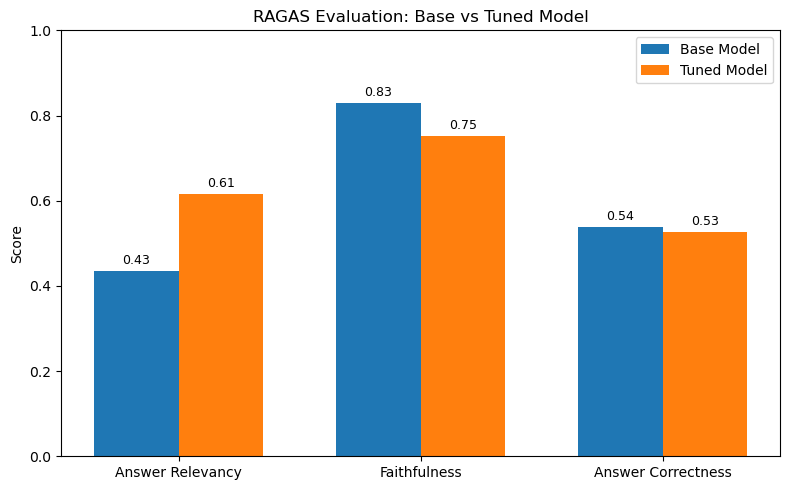

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Metric names and corresponding values for both models
metrics = ["Answer Relevancy", "Faithfulness", "Answer Correctness"]
base_scores = [base_evals_results_dict["answer_relevancy"], base_evals_results_dict["faithfulness"], base_evals_results_dict["answer_correctness"]]
tuned_scores = [tuned_evals_results_dict["answer_relevancy"], tuned_evals_results_dict["faithfulness"], tuned_evals_results_dict["answer_correctness"]]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, base_scores, width, label='Base Model')
bars2 = ax.bar(x + width/2, tuned_scores, width, label='Tuned Model')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('RAGAS Evaluation: Base vs Tuned Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

# Add value labels on top
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()